# Application Demo

As of October 8th, 2020, all the application functions are packaged in this toolkit. In the following cells, a sample behaviour is shown, where all the toolkit is put to the test.

## Stage 0: Loading all needed data upfront 

In [1]:
%%time

from tfgpkg.preproc.binarize import IlluminationBinarizer
from tfgpkg.preproc.line import LineSegmentation
from tfgpkg.preproc.word import WordSegmentation
from tfgpkg.preproc.paragraph import ParagraphSegmentation
from tfgpkg.recognition.word import RecognitionNet, StringVectorizer, Arch
from tfgpkg.recognition.color import ColorExtractor, ColorGroup
from tfgpkg.recognition import HighlightDetector, TextChecker
from tfgpkg.languages import LanguageTransformer, HTMLMinidownColorListener

from tfgpkg.utils import Printer
from IPython.display import IFrame
from PIL import Image

import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import sys
import cv2
import os

if sys.version_info.minor < 7:
    import importlib_resources as pkg_resources
elif sys.version_info.minor >= 7:
    import pkg_resources
    
plt.rcParams['figure.figsize'] = (10, 9)

Wall time: 4.39 s


## Stage 1: Input & Pre-processing

### Stage 1.1: Load the image & binarize it

Wall time: 1.29 s
Image size: (3084, 2315)


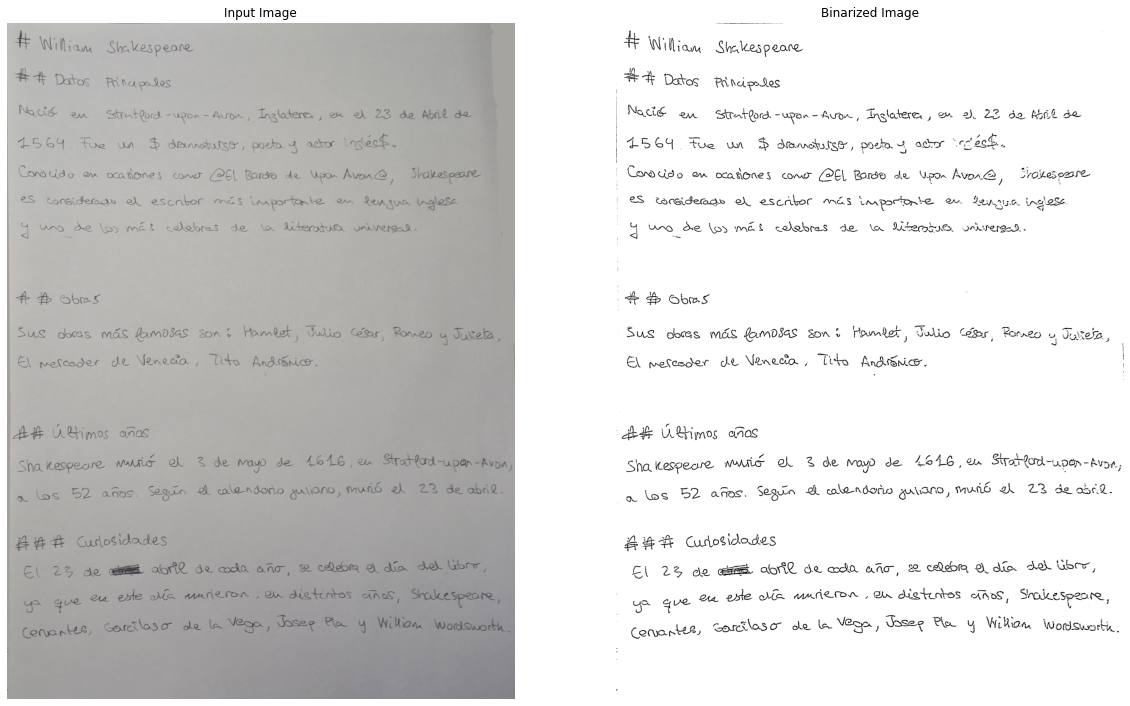

In [2]:
input_image_fpath = "../../data-sources/spanish-words-originals/test3.jpg"
input_image = IlluminationBinarizer.imread(input_image_fpath)

%time bin_image = IlluminationBinarizer.illumination_compensation(input_image, bl=290, as_bin=True, upper_value=255)

print(f"Image size: {bin_image.shape}")

Printer([input_image, bin_image], ["Input Image", "Binarized Image"], (20,15)).print_(flip=True)

In [2]:
save_it = False

if save_it:
    for i, image in enumerate([input_image, bin_image]):
        im = Image.fromarray(image)
        im.save(f"demo_checkpoint0_{i}.png")
else:
    input_image, bin_image = [IlluminationBinarizer.imread(f"demo_checkpoint0_{i}.png", grayscale=gray)
                              for i, gray in [(0, False), (1, True)]]

---

### Stage 1.2.1: Text Segmentation

#### Stage 1.2.1.1: Line segmentation

In [3]:
%time line_images, line_coords = LineSegmentation(bin_image).find_lines(strip_whites=True, buffer_lines=20, whitest_range=20)

print(f"Number of lines found: {len(line_images)}")

Wall time: 1.5 s
Number of lines found: 17


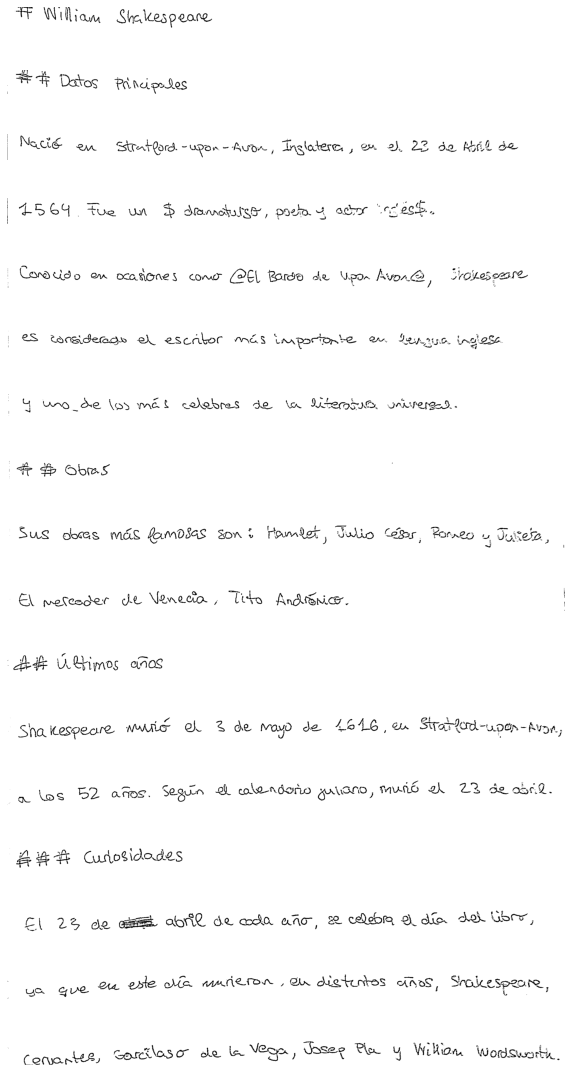

In [4]:
Printer(line_images, None, (10, 20)).print_(only_vertical=True)

#### Stage 1.2.1.2: Paragraph segmentation

In [5]:
%%time

paragraphs = ParagraphSegmentation(line_coords).get_lines_with_paragraphs() # List[image, (start, end), paragraph]

print("Number of paragraphs found: ", len(set(paragraphs)))

for i, p in enumerate(paragraphs):
    print(f"Line {i} belongs to paragraph {p}")

Number of paragraphs found:  4
Line 0 belongs to paragraph 0
Line 1 belongs to paragraph 0
Line 2 belongs to paragraph 0
Line 3 belongs to paragraph 0
Line 4 belongs to paragraph 0
Line 5 belongs to paragraph 0
Line 6 belongs to paragraph 0
Line 7 belongs to paragraph 1
Line 8 belongs to paragraph 0
Line 9 belongs to paragraph 0
Line 10 belongs to paragraph 1
Line 11 belongs to paragraph 0
Line 12 belongs to paragraph 0
Line 13 belongs to paragraph 2
Line 14 belongs to paragraph 0
Line 15 belongs to paragraph 0
Line 16 belongs to paragraph 3
Wall time: 30 ms


#### Stage 1.2.1.3: Word segmentation

Wall time: 650 ms


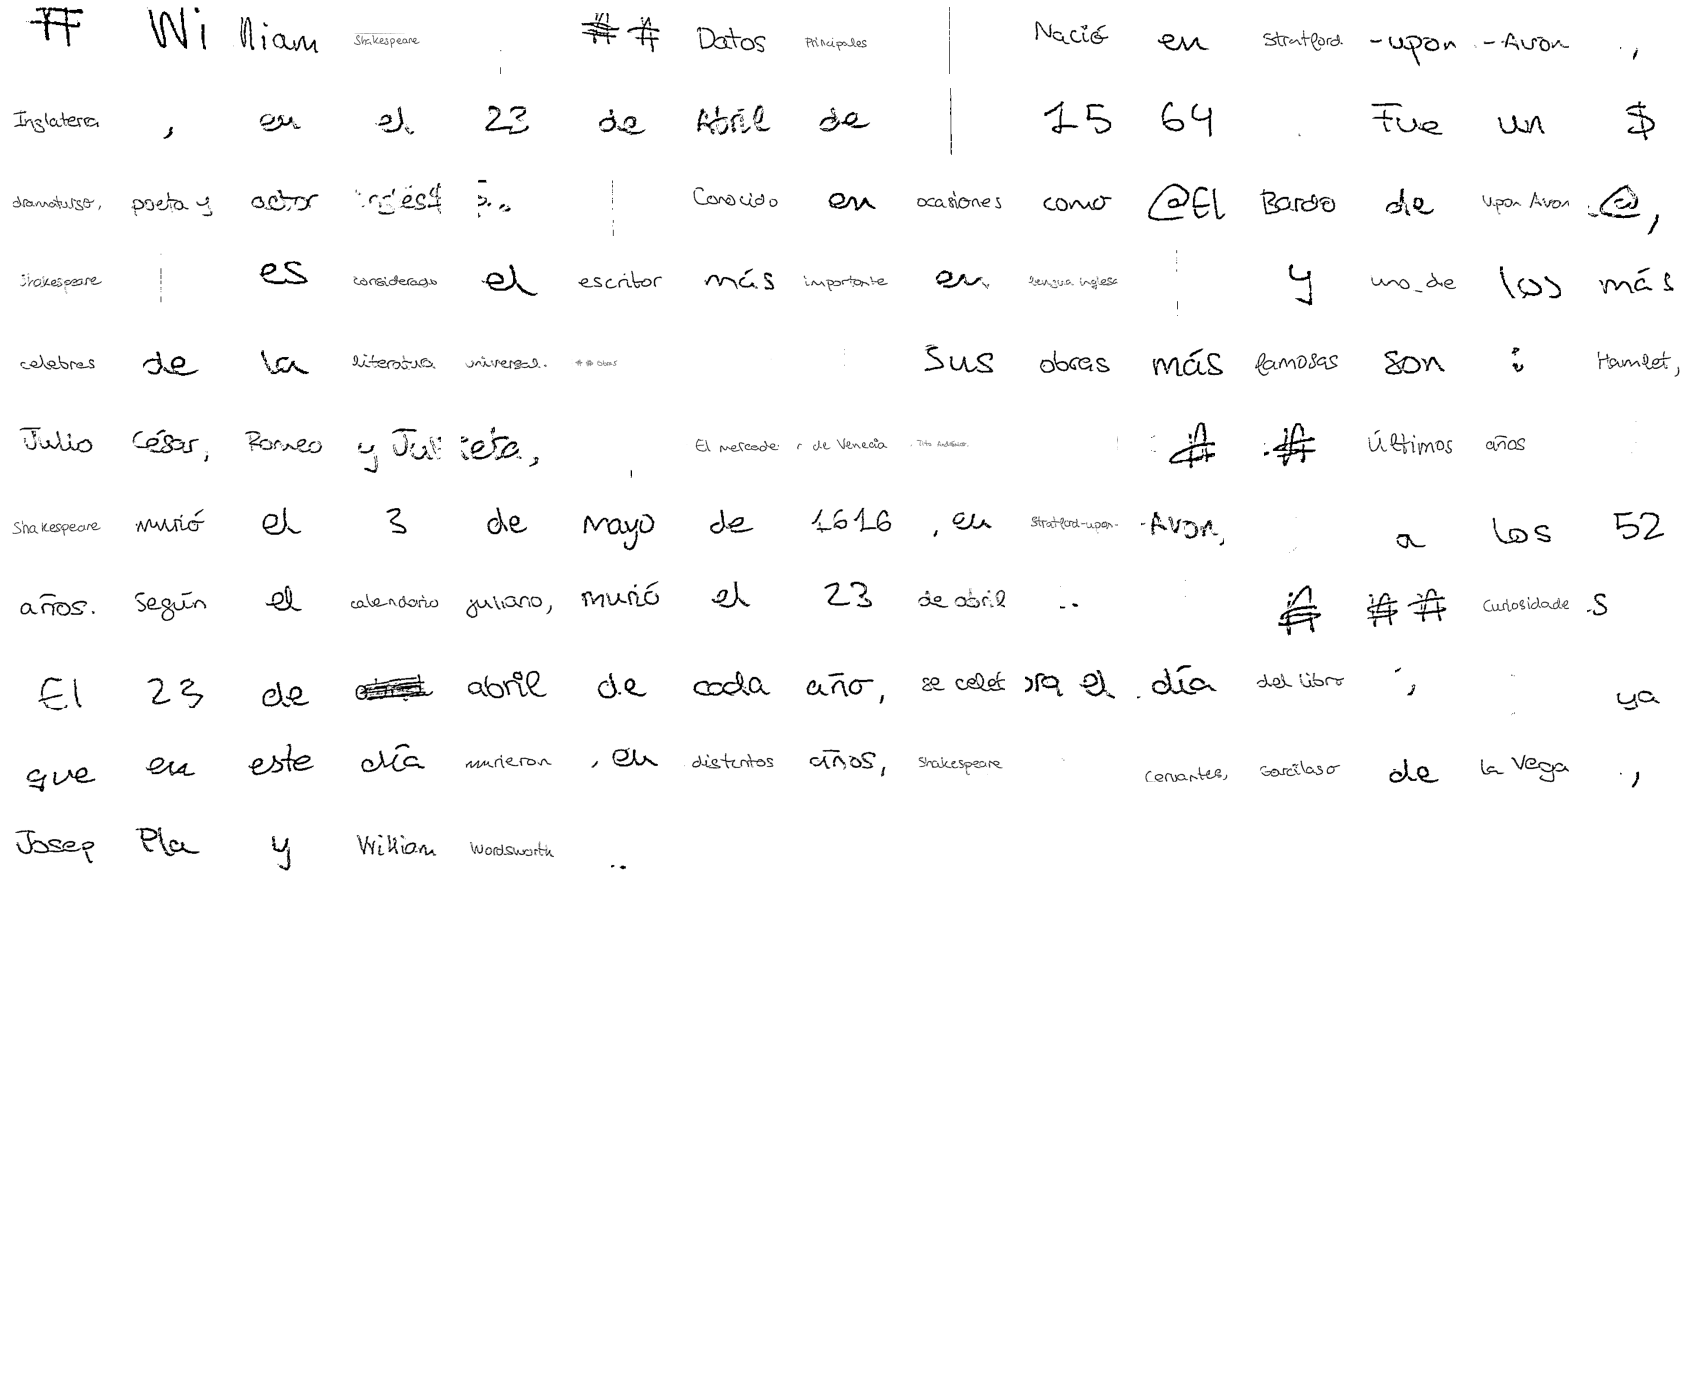

In [6]:
%time all_words = [WordSegmentation(line, coords).get_words() for line, coords in zip(line_images, line_coords)]

word_images, word_coords = [wrd for wrd, _ in all_words], [coords for _, coords in all_words]

Printer(word_images, figsize=(30, 25)).print_(nested_lists=True)

In [7]:
flat_word_images = WordSegmentation.flatten_word_list(word_images)
flat_word_coords = WordSegmentation.flatten_word_list(word_coords)

print("Total number of words: ", len(flat_word_images))

Total number of words:  156


In [22]:
save_it = False

if save_it:
    demo_checkpoint1 = np.array(word_images, dtype=object)
    np.save("demo_checkpoint1.npy", demo_checkpoint1)
else:
    word_images = list(np.load("demo_checkpoint1.npy", allow_pickle=True))

---

## Stage 2: Text & Color Recognition

### Stage 2.1: Text recognition

#### Stage 2.1.1: Text recognition

In [31]:
# set image size and ratio
width, height = TARGET_SIZE = (192, 48)
IMAGE_RATIO = width / height

# get path to saved model
MODEL_PATH = pkg_resources.resource_filename("tfgpkg.recognition.data", "crnn_model_1e_weights.ckpt")

In [27]:
text_net = RecognitionNet(logdir=".", input_size=(*TARGET_SIZE, 1), arch=Arch.Gated)

if os.path.exists(MODEL_PATH):
    text_net.load_chkpt(MODEL_PATH)
else:
    raise ValueError("Path not valid: ", MODEL_PATH)

In [30]:
lines_to_recognize_text = [words[0], words[-2]]

config = {"aspect_ratio": IMAGE_RATIO, "target_size": (width, height)}
processed_lines = [RecognitionNet.preprocess(wrd, **config) for wrd, _ in line for line in lines_to_recognize_text]

OSError: Unable to open file (file signature not found)

In [ ]:
%%time

print("Words to recognize: ", np.product((len(line) for line in lines_to_recognize_text)))

recognized_lines, vectorizer = [], StringVectorizer()
for line in processed_lines:
    preds, _ = text_net.predict(np.array(line))

    recognized_lines.append([vect.decode(pred_word.flatten()) for pred_word in preds])

In [ ]:
longest_line_sz = max([len(line) for line in lines_to_recognize_text])

_, axes = plt.subplots(len(lines_to_recognize_text), longest_line_sz, figsize=(15,7))

for i, line in enumerate(lines_to_recognize_text):       
    for j, (word, _) in enumerate(line):
        recognized_word = recognized_lines[i][j]
        
        axes[i, j].imshow(word, cmap="gray")
        axes[i, j].set_title(recognized_word)
        axes[i, j].axis("off")
        
    for k in range(j, longest_line_sz):
        axes[i, k].axis("off")
    
plt.show()

In [ ]:
for line in recognized_lines:
    print(line)

#### Stage 2.1.2: Spell checking

In [47]:
lines_to_recognize_text = [
    ["Conocido", "en", "ocasiones", "como", "el", "bardo"],
    ["de", "Upon", "Avon", ", Shakespeare"]
]

In [ ]:
%time checked_lines = TextChecker(lines_to_recognize_text).correct()

for line in checked_lines:
    print(line)

In [16]:
save_it = True

if save_it:
    demo_checkpoint21 = np.array(checked_lines, dtype=object)
    np.save("demo_checkpoint21.npy", demo_checkpoint1)
else:
    checked_lines = list(np.load("demo_checkpoint21.npy"))

C:\Users\Pachacho\miniconda3\envs\tfg\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


---

### Stage 2.2: Color Recognition

#### Stage 2.2.1: Highlight detection

In [9]:
COLOR_TARGET_SIZE = (150, 150)

color_net = HighlightDetector(target_size=(*COLOR_TARGET_SIZE, 3))
color_net.load_model()

c:\users\pachacho\documents\tfg_2020\src\packages\tfgpkg\preproc\word\quantization.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_colors, random_state=0).fit(sample)
c:\users\pachacho\documents\tfg_2020\src\packages\tfgpkg\preproc\word\quantization.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_colors, random_state=0).fit(sample)


(158, 150, 150, 3)


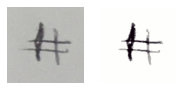

In [10]:
%%time

def process_word(word):
    resized = cv2.resize(word, COLOR_TARGET_SIZE, cv2.INTER_CUBIC)
    return HighlightDetector.preprocess(resized, brightness=20, contrast_gain=.05)
    
flat_color_word_images = (input_image[xmin:xmax, ymin:ymax, :] for (xmin, ymin, xmax, ymax) in flat_word_coords)
processed_color_word_images = np.array([process_word(word) for word in flat_color_word_images])  # now that all of them are of the same size

print(processed_color_word_images.shape)

Printer([flat_color_word_images[1], processed_color_word_images[1]], figsize=(3,3)).print_(flip=True)

In [12]:
%time preds = color_net.predict(processed_color_word_images)
pred_classes = [HighlightDetector.decode(prediction) for prediction in preds]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Wall time: 732 ms


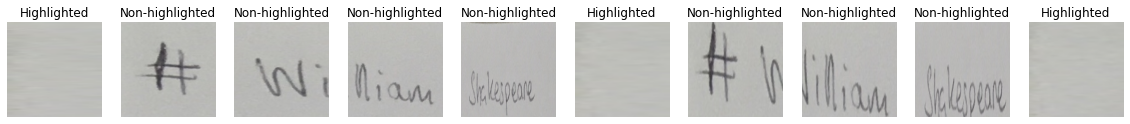

In [17]:
Printer(flat_color_word_images[:10], pred_classes[:10], figsize=(20,15)).print_(flip=True)

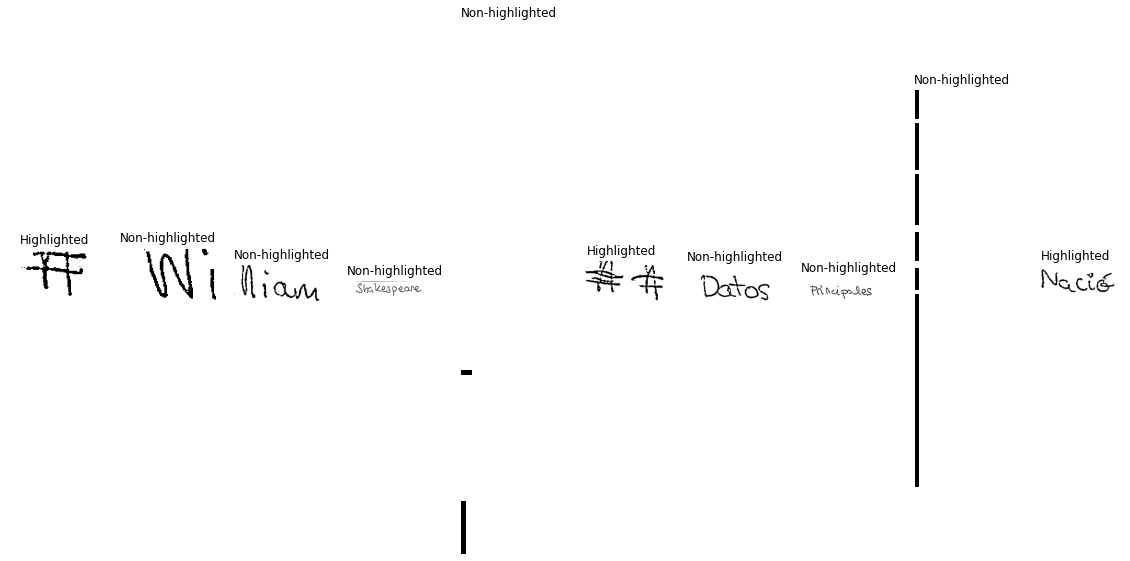

In [18]:
Printer(flat_word_images[:10], pred_classes[:10], figsize=(20,15)).print_(flip=True)

In [19]:
pred_classes_bool = [False if "Non" in color_class else True for color_class in pred_classes]

#### Stage 2.2.2: Color extraction

In [20]:
%time palettes = [ColorExtractor(word).palette(num_colors=3) for word in processed_color_words]

C:\Users\Pachacho\miniconda3\envs\tfg\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.22.2.post1 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Wall time: 16.4 s


In [21]:
palettes[:10]

[[array([[204, 188, 108]]),
  array([[212, 252, 132]]),
  array([[252, 252, 188]])],
 [array([[252, 252, 252]]), array([[42, 34, 46]]), array([[180, 172, 172]])],
 [array([[252, 252, 252]]), array([[61, 61, 61]]), array([[196, 196, 196]])],
 [array([[252, 252, 252]]), array([[12,  4,  4]]), array([[132, 124, 124]])],
 [array([[252, 252, 252]]), array([[79, 66, 71]]), array([[196, 188, 188]])],
 [array([[204, 252, 132]]),
  array([[204, 188, 116]]),
  array([[252, 252, 196]])],
 [array([[252, 252, 252]]), array([[55, 52, 55]]), array([[188, 180, 180]])],
 [array([[252, 252, 252]]), array([[4, 4, 4]]), array([[212, 212, 212]])],
 [array([[252, 252, 252]]), array([[91, 83, 91]]), array([[204, 204, 204]])],
 [array([[196, 252, 100]]),
  array([[188, 172, 116]]),
  array([[140, 156,   4]])]]

#### Stage 2.2.3: Color to CSS color names

In [ ]:
%time predictor = ColorGroup()

In [23]:
%time css_palettes = [[predictor.predict(color) for color in palette] for palette in palettes]
css_palettes[:10]

Wall time: 220 ms


[['yellow', 'white', 'white'],
 ['white', 'purple', 'white'],
 ['white', 'purple', 'white'],
 ['white', 'black', 'green'],
 ['white', 'purple', 'white'],
 ['white', 'yellow', 'white'],
 ['white', 'purple', 'white'],
 ['white', 'black', 'white'],
 ['white', 'purple', 'white'],
 ['yellow', 'yellow', 'green']]

In [19]:
save_it = True

if save_it:
    demo_checkpoint22 = (palettes, pred_classes_bool)
    with open("demo_checkpoint22.pkl", "wb") as f:
        pkl.dump(demo_checkpoint22, f)
else:
    with open("demo_checkpoint22.pkl", "rb") as f:
        palettes, pred_classes_bool = pkl.load(f)

## Stage 3: Text Processing

### Stage 3.1: Collect color & text inputs

In [43]:
sample_text = ["Un", "caballo", "azul"]
sample_color = [['yellow', 'black', 'black'], ['white', 'purple', 'white'], ['white', 'purple', 'white']]
sample_pred = [True, False, False]

In [44]:
transformer_input = LanguageTransformer.collect_word_color(sample_color, sample_pred, sample_text)
print(transformer_input)

(Un , black , yellow) (caballo , purple , None) (azul , purple , None)


In [84]:
# transformer_input = "(A , black , yellow) (blue , black , yellow) (horse , black , None)"

### Stage 3.2: Transform the collected input into HTML5

In [45]:
_ = LanguageTransformer(
    listener=HTMLMinidownColorListener,
    text_input=transformer_input,
    output_fpath="demo.html"
)

In [ ]:
save_it = True

if save_it:    
    demo_checkpoint3 = transformer_input
    with open("demo_checkpoint3.pkl", "wb") as f:
        pkl.dump(demo_checkpoint3, f)
else:
    with open("demo_checkpoint3.pkl", "rb") as f:
        transformer_input = pkl.load(f)

# Result

In [46]:
IFrame(src='./demo.html', width=700, height=300)